In [2]:
import pandas as pd
import numpy as np

## Importing and Preprocessing Data

In [3]:
x = pd.read_csv('random_sets.csv').iloc[:125,:]
split = x['Numbers'].str.split(",")
x = np.zeros((125, 20))
for i in range(125):
    idx = np.array(split[i], dtype=int)-1
    x[i,idx] = 1
y = pd.read_csv('total_travel_time.csv')['total_travel_time'].to_numpy()

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


## RandomForest Regression

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
grid = {'n_estimators': [i for i in range(1,20)],
        'min_samples_split': [i for i in range(2,10)],
        'max_features' : [i for i in range(8, 20, 2)]}
cv_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1171977.7108826446 RMSE:  1362143.061204258


In [11]:
fitted.best_estimator_

RandomForestRegressor(max_features=14, min_samples_split=8, n_estimators=10)

In [15]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))

MAE:  722368.761776514 RMSE:  855548.0940571589


## XGBoost

In [16]:
from xgboost import XGBRegressor
grid = {'n_estimators': [i for i in range(1,20)]}
cv_rf = GridSearchCV(estimator = XGBRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [17]:
sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2624167.76 RMSE:  2922967.6999258134


In [19]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))

MAE:  2797879.63 RMSE:  3045582.6903246953


## NN

In [219]:
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))


input_shape = (x_train.shape[0], x_train.shape[1])


model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(258, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1))
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer='adam')
model.fit(x_train_nn, y_train_nn[:,np.newaxis],epochs=500, batch_size=32)


Epoch 1/500


/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 0s 2ms/step - loss: 1.0289
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8024
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.6649
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5529
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.4654
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3909
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 0.3283
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2993
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2390
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2211
Epoch 11/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1783
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1626
Epoch 13/500
4/4 [==============================] - 0s 1ms/step - loss: 0

In [221]:
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

predicted = model.predict(x_test_nn)
predicted = y_scaler.inverse_transform(predicted)

1/1 [==============================] - 0s 65ms/step


In [222]:
print('MAE: ', mean_absolute_error(y_test, predicted), 'RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))

MAE:  1181457.12 RMSE:  1410761.444876064


## GA Optimziation

In [136]:
class GA:
    def __init__(self, population, model):
        self.population = population
        self.model = model


    def eval(self):
        self.y_predicted = self.model.best_estimator_.predict(self.population)
        sorted_idx = np.argsort(self.y_predicted)
        self.population = self.population[sorted_idx]

    def crossover(self, num_cross_overs):
        for i in range(0, 2*num_cross_overs, 2):
            cutoff = np.random.randint(5,15)
            recombined_i = np.concatenate([self.population[i, :cutoff], self.population[i+1, cutoff:]])
            recombined_i_1 = np.concatenate([self.population[i+1, :cutoff], self.population[i, cutoff:]])

            self.population[i] = recombined_i
            self.population[i+1] = recombined_i_1
    
    def mutation(self, num_mutations, num_each=1):
        for i in range(num_mutations):
            sample = self.population[i]
            mute_genes = np.random.randint(0, 20, num_each)
            sample[mute_genes] = abs(sample[mute_genes] - 1)
            self.population[i] = sample



In [137]:
pop = GA(x, fitted)
for i in range(1000):
    pop.eval()
    pop.crossover(50)
    pop.mutation(50)
pop.eval()

In [138]:
pop.population[0]

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1.])

In [139]:
pop.y_predicted[0]

2264386475.6785717

In [140]:
y < pop.y_predicted[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [123]:
np.any(np.array([np.array_equal(row, pop.population[0]) for row in x]))
## False means it's not one of the solutions found in the original problem


False

In [149]:
test_set = pd.read_csv('test_set2.csv')

In [231]:
test_set['num_steps'].sum() < y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

[Text(0.5, 1.0, 'Savings with the Optimal Set'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Travel Time Difference (M)'),
 (-20000000.0, 0.0)]

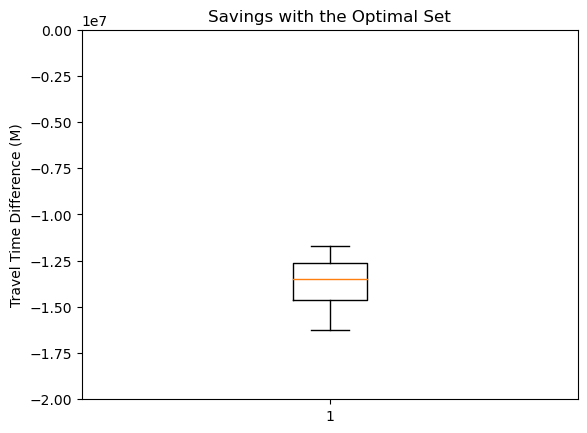

In [249]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.boxplot(test_set['num_steps'].sum() - y)
ax.set(title='Savings with the Optimal Set',
       xlabel='',
       ylabel='Travel Time Difference (M)',
       ylim=(-2*10**7, 0))